In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import itertools
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

In [2]:
# CSV 파일 로드
file_path = 'C:/Users/manci/Desktop/멀티잇_부트캠프/최종파이널_프로젝트/환율예측/data/딥러닝및머신러닝논문/2019.csv'

df = pd.read_csv(file_path)

# 날짜 칼럼 --> datetime 형태로 변환
df['날짜'] = pd.to_datetime(df['날짜'])


# 날짜 칼럼을 인덱스로 설정
df.set_index('날짜', inplace=True)

# Feature Engineering: 이동평균 및 과거 환율 값 추가
df['환율_7일_평균'] = df['환율'].rolling(window=7).mean()

for i in range(1,8):
    df[f'환율_{i}일전'] = df['환율'].shift(i)
df.dropna(inplace=True)
df

,환율,EUR_KRW,GBP_KRW,JPY_KRW,EUR_USD,GBP_USD,JPY_USD,다우존스,S&P500,나스닥,...,WTI,KOSPI지수,환율_7일_평균,환율_1일전,환율_2일전,환율_3일전,환율_4일전,환율_5일전,환율_6일전,환율_7일전
날짜,,,,,,,,,,,,,,,,,,,,,
2019-01-11,1118.9,1284.599976,1423.500000,10.306000,1.151013,1.275396,0.009234,23995.949219,2596.260010,6971.479980,...,51.44,2075.57,1121.700000,1121.6,1121.7,1118.0,1125.2,1127.5,1119.0,1118.1
2019-01-14,1117.6,1281.500000,1437.000000,10.309000,1.146014,1.284984,0.009220,23909.839844,2582.610107,6905.919922,...,50.31,2064.52,1121.500000,1118.9,1121.6,1121.7,1118.0,1125.2,1127.5,1119.0
2019-01-15,1121.4,1286.800049,1444.000000,10.361000,1.147289,1.287498,0.009238,24065.589844,2610.300049,7023.830078,...,51.80,2097.18,1120.628571,1117.6,1118.9,1121.6,1121.7,1118.0,1125.2,1127.5
2019-01-16,1120.1,1281.099976,1444.699951,10.331000,1.141683,1.287217,0.009204,24207.160156,2616.100098,7034.689941,...,52.08,2106.10,1119.900000,1121.4,1117.6,1118.9,1121.6,1121.7,1118.0,1125.2
2019-01-17,1122.0,1274.400024,1441.500000,10.260000,1.139809,1.288577,0.009171,24370.099609,2635.959961,7084.459961,...,51.83,2107.06,1120.471429,1120.1,1121.4,1117.6,1118.9,1121.6,1121.7,1118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15,1376.3,1469.267334,1781.827881,8.679485,1.088554,1.296680,0.006317,40211.718750,5631.220215,18472.570312,...,83.22,2860.92,1380.814286,1380.1,1385.6,1383.4,1379.4,1379.0,1381.9,1389.4
2024-07-16,1381.9,1507.609985,1794.552856,8.749447,1.090156,1.297000,0.006323,40954.480469,5667.200195,18509.339844,...,83.22,2866.09,1380.814286,1376.3,1380.1,1385.6,1383.4,1379.4,1379.0,1381.9
2024-07-17,1386.0,1506.310059,1794.226562,8.731158,1.090251,1.297769,0.006315,41198.078125,5588.270020,17996.919922,...,83.22,2843.29,1381.814286,1381.9,1376.3,1380.1,1385.6,1383.4,1379.4,1379.0


In [3]:
# 정답 컬럼 생성
df.loc[:,'target'] = df.loc[:,'환율']

X = df.iloc[:, :-1]
y = df.loc[:,['target']]

# 정규화 진행
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# LSTM 입력 데이터 형태 변환
def make_dataset(X, y, time_steps):
    X_data_total = []
    y_data_total = []
    for start in np.arange(len(X)-time_steps):
        stop = start + time_steps
        # X_data --> 슬라이싱
        X_data = X[start:stop, :]
        X_data_total.append(X_data)
        # y_data --> 인덱싱
        y_data = y[stop]
        y_data_total.append(y_data)
    return np.array(X_data_total), np.array(y_data_total)

time_steps = 30
X_data,y_data = make_dataset(X = X_scaled, y = y_scaled, time_steps = time_steps)

# 학습용 / 평가용 데이터 생성
train_size = int(len(X_data) * 0.7)
valid_size = int(len(X_data) * 0.2)
test_size = len(X_data) - train_size - valid_size

X_train = X_data[0:train_size,:,:]
y_train = y_data[0:train_size,:]
X_valid = X_data[train_size:train_size + valid_size,:,:]
y_valid = y_data[train_size:train_size + valid_size,:]
X_test = X_data[train_size + valid_size:len(X_data),:,:]
y_test = y_data[train_size + valid_size:len(X_data),:]

In [4]:
# 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.2, 'optimizer': 'adam', 'epochs': 5,
# {'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.3, 'optimizer': 'adam', 'epochs': 10, 'regularization': 0.01}
# best_params = {'learning_rate': 0.001, 'batch_size': 16, 'dropout': 0.2, 'optimizer': 'adam', 'epochs': 50, 'regularization': 0.001}
# {'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.1, 'optimizer': 'adam', 'epochs': 50, 'regularization': 0.001}
# 2021 {'batch_size': 16, 'epochs': 50, 'learning_rate': 0.01, 'optimizer_choice': 'adam', 'regularization': 0.001}
# 2019 {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 20, 'regularization': 0.01}
# GRU {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 50, 'regularization': 0.01}
# 시드 고정
seed = 45
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 최적의 파라미터
best_params = {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 50, 'regularization': 0.01}

print(best_params)

{'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 50, 'regularization': 0.01}


In [5]:
# GRU 모델 정의
tf.keras.backend.clear_session()
model = Sequential()
model.add(GRU(16, kernel_regularizer=l2(best_params['regularization']),input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, kernel_regularizer=l2(best_params['regularization'])))

optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'],
                    validation_data=(X_valid, y_valid), shuffle=False, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

C:\Users\manci\anaconda3\envs\stl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.4767 - val_loss: 0.3569
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3552 - val_loss: 0.3059
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2762 - val_loss: 0.2856
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2361 - val_loss: 0.2607
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2026 - val_loss: 0.2284
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1841 - val_loss: 0.1894
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1529 - val_loss: 0.1600
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1318 - val_loss: 0.1400
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1230 - val_loss: 0.1317
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1104 - val_loss: 0.1328
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1037 - val_loss: 0.1316
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

In [6]:
# 예측
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)
test_predict = model.predict(X_test)

# 예측 값 정규화 이전으로 복원
train_predict = scaler_y.inverse_transform(train_predict)
valid_predict = scaler_y.inverse_transform(valid_predict)
test_predict = scaler_y.inverse_transform(test_predict)

# 원래 값 정규화 이전으로 복원
y_train_actual =  scaler_y.inverse_transform(y_train)
y_valid_actual =  scaler_y.inverse_transform(y_valid)
y_test_actual =  scaler_y.inverse_transform(y_test)


total_predict = np.concatenate([train_predict, valid_predict, test_predict])
total_actual = np.concatenate([y_train_actual, y_valid_actual, y_test_actual])

index = df.iloc[time_steps:].index
df_predict = pd.DataFrame(data = total_predict,index=index, columns=['예측환율'])
df_predict.loc[:,'실제환율'] = y.iloc[time_steps:].values
df_predict['예측환율'] = df_predict['예측환율'].astype(float).round(2)

# 인덱스를 '날짜' 칼럼으로 변환
df_predict.reset_index(inplace = True)
df_predict.rename(columns = {'index': '날짜'}, inplace = True)

print(df_predict)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
             날짜     예측환율    실제환율
0    2019-02-27  1137.58  1118.3
1    2019-02-28  1136.42  1117.8
2    2019-03-04  1135.60  1119.9
3    2019-03-05  1135.66  1125.0
4    2019-03-06  1135.55  1125.8
...         ...      ...     ...
1332 2024-07-15  1356.75  1376.3
1333 2024-07-16  1355.88  1381.9
1334 2024-07-17  1357.32  1386.0
1335 2024-07-18  1357.73  1381.5
1336 2024-07-19  1357.88  1379.9

[1337 rows x 3 columns]


In [7]:
### 성능 평가
def evaluate_performance(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, r2, mape

# 전체 데이터에 대한 성능 지표 계산
# overall_rmse, overall_mae, overall_r2, overall_mape = evaluate_performance(df_predict['실제환율'], df_predict['예측환율'])
# print(f'전체 RMSE: {overall_rmse}, 전체 MAE: {overall_mae}, 전체 R2: {overall_r2}, 전체 MAPE: {overall_mape}')
# print('-'*80)

overall_rmse, overall_mae, overall_r2, overall_mape = evaluate_performance(total_actual, total_predict)
print(f'전체 RMSE: {overall_rmse}, 전체 MAE: {overall_mae}, 전체 R2: {overall_r2}, 전체 MAPE: {overall_mape}')


print('-'*80)

# 각 데이터셋에 대한 성능 지표
train_rmse, train_mae, train_r2, train_mape = evaluate_performance(y_train_actual, train_predict)
valid_rmse, valid_mae, valid_r2, valid_mape = evaluate_performance(y_valid_actual, valid_predict)
test_rmse, test_mae, test_r2, test_mape = evaluate_performance(y_test_actual, test_predict)

print(f'Train RMSE: {train_rmse}, MAE: {train_mae}, R2: {train_r2}, MAPE: {train_mape}')
print('-'*80)
print(f'Valid RMSE: {valid_rmse}, MAE: {valid_mae}, R2: {valid_r2}, MAPE: {valid_mape}')
print('-'*80)
print(f'Test RMSE: {test_rmse}, MAE: {test_mae}, R2: {test_r2}, MAPE: {test_mape}')

전체 RMSE: 16.465361111126587, 전체 MAE: 13.573597825705871, 전체 R2: 0.9635268699149411, 전체 MAPE: 1.094980771509127
--------------------------------------------------------------------------------
Train RMSE: 15.829752695098634, MAE: 12.89452970943349, R2: 0.9533554882739046, MAPE: 1.073734888608095
--------------------------------------------------------------------------------
Valid RMSE: 16.164768317187107, MAE: 13.325394556852753, R2: 0.7009727180350939, MAPE: 1.0261126623169907
--------------------------------------------------------------------------------
Test RMSE: 20.80085856426105, MAE: 18.76766420717593, R2: 0.28659504261707036, MAPE: 1.3783339986703518


In [8]:
### 향후 30일 예측 - 일별
future_dates = pd.date_range(start = df.index[-1] + pd.Timedelta(days = 1), periods = 30, freq='B')

future_preds = []
input_data = np.array(X_scaled[-30:])

for date in future_dates:
    # input_data를 모델 입력 형태에 맞게 reshape
    input_data_reshaped = input_data.reshape(1, 30, -1)
    pred = model.predict(input_data_reshaped)
    future_preds.append(pred[0])

    # When creating new_row, ensure all features are included
    new_row = np.append(input_data[0, 1:], pred[0])
    input_data = np.append(input_data[1:], new_row.reshape(1, -1), axis=0)

future_preds = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 소수점 둘째자리까지 반올림
future_preds = np.round(future_preds, 2)

# 미래 예측 데이터프레임
future_df = pd.DataFrame({'예측날짜_일별': future_dates, '예측환율_일별':  future_preds.flatten()})

### 주말 포함 병합
dates = pd.date_range(start = df.index[-1] + pd.Timedelta(days = 1), periods = 42, freq='D')
new = pd.DataFrame({'예측날짜_일별' : dates})
pred_dates_df = pd.merge(new, future_df, on = '예측날짜_일별', how = 'left')

# 병합한 데이터 따로 저장
pred_dates_30 = pred_dates_df

# 원래 데이터 - 주말에는 금요일 환율로 대체
pred_dates_df = pred_dates_df.fillna(method = 'ffill')

# 예측 환율의 오차범위 만들기 - 예측환율_일별_최소 칼럼, 예측환율_일별_최대 칼럼 생성(소수점 둘째자리까지)
pred_dates_df['예측환율_일별'] = pred_dates_df['예측환율_일별'].apply(lambda x : round(x, 2))
pred_dates_df['예측환율_일별_최소'] = np.round(pred_dates_df['예측환율_일별'] - 1.96*np.std(pred_dates_df['예측환율_일별']), 2)
pred_dates_df['예측환율_일별_최대'] = np.round(pred_dates_df['예측환율_일별'] + 1.96*np.std(pred_dates_df['예측환율_일별']), 2)
pred_dates_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

C:\Users\manci\AppData\Local\Temp\ipykernel_31832\3333942387.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pred_dates_df = pred_dates_df.fillna(method = 'ffill')


,예측날짜_일별,예측환율_일별,예측환율_일별_최소,예측환율_일별_최대
0,2024-07-20,NaN,NaN,NaN
1,2024-07-21,NaN,NaN,NaN
2,2024-07-22,1358.44,1348.03,1368.85
3,2024-07-23,1371.48,1361.07,1381.89
4,2024-07-24,1377.89,1367.48,1388.30
5,2024-07-25,1380.31,1369.90,1390.72
6,2024-07-26,1382.18,1371.77,1392.59
7,2024-07-27,1382.18,1371.77,1392.59
8,2024-07-28,1382.18,1371.77,1392.59
9,2024-07-29,1382.70,1372.29,1393.11


In [9]:
### 일별 예측 저장
file_path1 = 'C:/Users/manci/Desktop/멀티잇_부트캠프/최종파이널_프로젝트/환율예측/data/딥러닝및머신러닝논문/환율예측_일별_GRU(주말대체함).csv'

pred_dates_df.to_csv(file_path1, index = False)

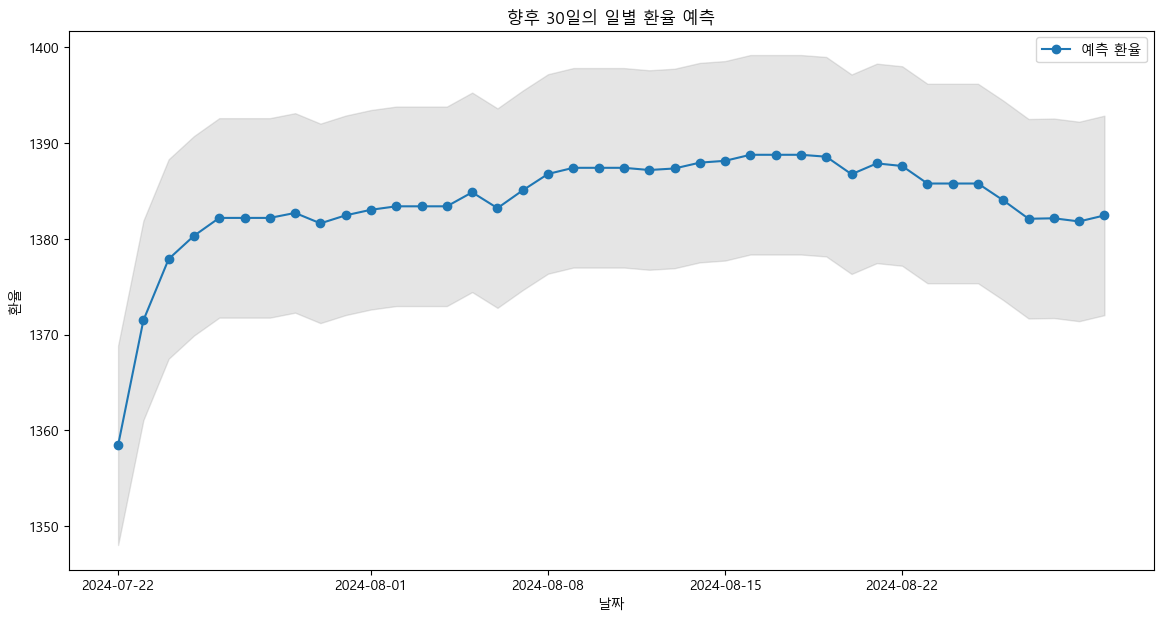

In [10]:
# 일별 예측 환율 시각화
plt.figure(figsize=(14, 7))
plt.plot(pred_dates_df['예측날짜_일별'], pred_dates_df['예측환율_일별'], label = '예측 환율', marker = 'o')
plt.fill_between(pred_dates_df['예측날짜_일별'], (pred_dates_df['예측환율_일별'] - 1.96*np.std(pred_dates_df['예측환율_일별'])), 
                 (pred_dates_df['예측환율_일별'] + 1.96*np.std(pred_dates_df['예측환율_일별'])), color='gray', alpha=0.2)
plt.title('향후 30일의 일별 환율 예측')
plt.xlabel('날짜')
plt.ylabel('환율')
plt.legend()
plt.show()

In [11]:
# 주말 제외 데이터
pred_dates_30['예측환율_일별'] = pred_dates_30['예측환율_일별'].apply(lambda x : round(x, 2))
pred_dates_30['예측환율_일별_최소'] = np.round(pred_dates_30['예측환율_일별'] - 1.96*np.std(pred_dates_30['예측환율_일별']), 2)
pred_dates_30['예측환율_일별_최대'] = np.round(pred_dates_30['예측환율_일별'] + 1.96*np.std(pred_dates_30['예측환율_일별']), 2)
pred_dates_30

,예측날짜_일별,예측환율_일별,예측환율_일별_최소,예측환율_일별_최대
0,2024-07-20,NaN,NaN,NaN
1,2024-07-21,NaN,NaN,NaN
2,2024-07-22,1358.44,1346.94,1369.94
3,2024-07-23,1371.48,1359.98,1382.98
4,2024-07-24,1377.89,1366.39,1389.39
5,2024-07-25,1380.31,1368.81,1391.81
6,2024-07-26,1382.18,1370.68,1393.68
7,2024-07-27,NaN,NaN,NaN
8,2024-07-28,NaN,NaN,NaN
9,2024-07-29,1382.70,1371.20,1394.20


In [12]:
# 주말 제외 데이터 저장
file_path5 = 'C:/Users/manci/Desktop/멀티잇_부트캠프/최종파이널_프로젝트/환율예측/data/딥러닝및머신러닝논문/환율예측_일별_GRU(주말NaN값).csv'

pred_dates_30.to_csv(file_path5, index = False)

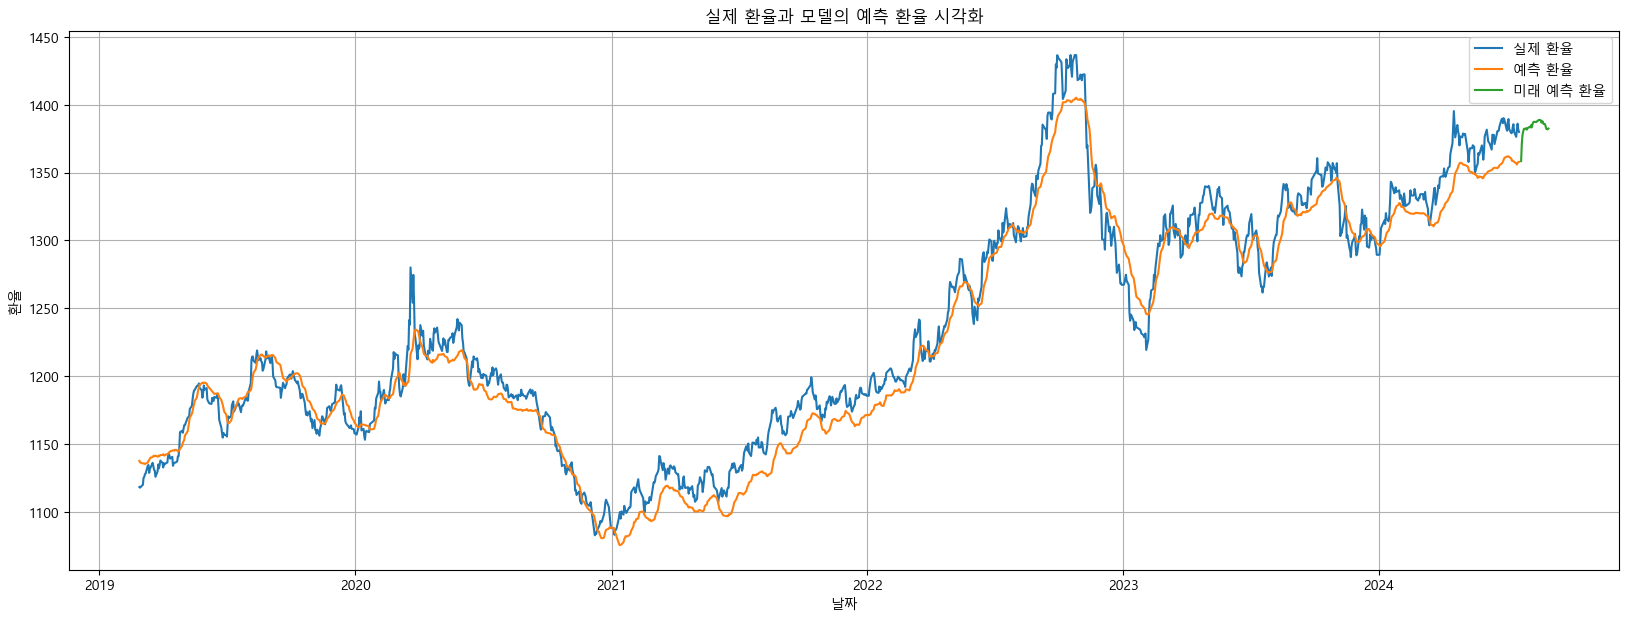

In [13]:
### model --> 결과 시각화
plt.figure(figsize=(20,7))
# df_predict.loc[:,['실제환율','예측환율']].plot(kind='line')
# Convert '예측날짜' to datetime objects and extract dates
plt.plot(df_predict['날짜'], df_predict['실제환율'], label = '실제 환율')
plt.plot(df_predict['날짜'], df_predict['예측환율'], label = '예측 환율', linestyle = 'solid')

# Convert '예측날짜' to datetime objects and extract dates
plt.plot(pd.to_datetime(pred_dates_df['예측날짜_일별']).dt.date, pred_dates_df['예측환율_일별'], 
         label = '미래 예측 환율', linestyle = 'solid')

#plt.fill_between(df_predict['날짜'],  (df_predict['예측환율'] - 1.96*np.std(total_predict)), (df_predict['예측환율'] + 1.96*np.std(total_predict)), color = 'gray', alpha=0.2)
plt.title('실제 환율과 모델의 예측 환율 시각화')
plt.xlabel('날짜')
plt.ylabel('환율')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
### 3개월 월별 예측
future_days = 60
future_month_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days, freq='B')

input_data = np.array(X_scaled[-30:])
future_month_preds = []

for date in future_month_dates:
    input_data_reshaped = input_data.reshape(1, 30, -1)
    pred1 = model.predict(input_data_reshaped)
    future_month_preds.append(pred1[0])
    new_row = np.append(input_data[0, 1:], pred1[0])
    input_data = np.append(input_data[1:], new_row.reshape(1, -1), axis=0)

future_month_preds = scaler_y.inverse_transform(np.array(future_month_preds).reshape(-1, 1))
future_month_preds = np.round(future_month_preds, 2)

# 미래 예측 데이터프레임
future_month_df = pd.DataFrame({'예측날짜_월별': future_month_dates, '예측환율_월별': future_month_preds.flatten()})

### 주말 포함 병합
dates1 = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days, freq='D')
new1 = pd.DataFrame({'예측날짜_월별': dates1})
pred_month_df = pd.merge(new1, future_month_df, on='예측날짜_월별', how='left')
pred_month_df = pred_month_df.fillna(method='ffill')

# 월별 마지막 예측환율 값 찾기
pred_month_df['예측날짜_월별'] = pred_month_df['예측날짜_월별'].dt.to_period('M')
last_day_preds = pred_month_df.groupby('예측날짜_월별').last().reset_index()
last_day_preds.columns = ['예측날짜_월별', '예측환율_월별']

# 월별 마지막 예측환율 값 --> 월별 데이터로 넣기(날짜 형태 연도-월)
last_day_preds['예측날짜_월별'] = last_day_preds['예측날짜_월별'].dt.strftime('%Y-%m')
last_day_preds['예측환율_월별'] = last_day_preds['예측환율_월별'].apply(lambda x: round(x, 2))
last_day_preds['예측환율_월별_최소'] = np.round(last_day_preds['예측환율_월별'] - 1.96 * np.std(last_day_preds['예측환율_월별']), 2)
last_day_preds['예측환율_월별_최대'] = np.round(last_day_preds['예측환율_월별'] + 1.96 * np.std(last_day_preds['예측환율_월별']), 2)
last_day_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

C:\Users\manci\AppData\Local\Temp\ipykernel_31832\3956820531.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pred_month_df = pred_month_df.fillna(method='ffill')


,예측날짜_월별,예측환율_월별,예측환율_월별_최소,예측환율_월별_최대
0,2024-07,1382.45,1354.56,1410.34
1,2024-08,1382.44,1354.55,1410.33
2,2024-09,1352.26,1324.37,1380.15


In [16]:
### 월별 예측 저장
file_path2 = 'C:/Users/manci/Desktop/멀티잇_부트캠프/최종파이널_프로젝트/환율예측/data/딥러닝및머신러닝논문/환율예측_월별_GRU.csv'

last_day_preds.to_csv(file_path2, index = False)


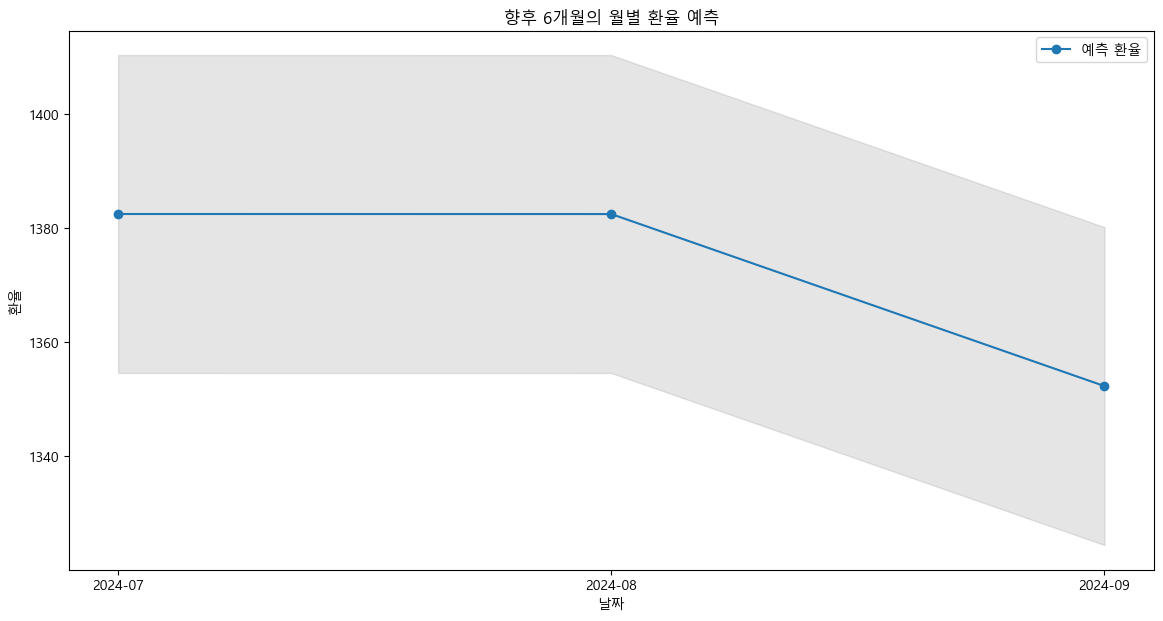

In [17]:
### 향후 3개월의 예측 환율 시각화
plt.figure(figsize=(14, 7))
plt.plot(last_day_preds['예측날짜_월별'], last_day_preds['예측환율_월별'], label = '예측 환율', marker = 'o')
plt.fill_between(last_day_preds['예측날짜_월별'], (last_day_preds['예측환율_월별'] - 1.96 * np.std(last_day_preds['예측환율_월별'])),
                 (last_day_preds['예측환율_월별'] + 1.96 * np.std(last_day_preds['예측환율_월별'])), color='gray', alpha=0.2)
plt.title('향후 6개월의 월별 환율 예측')
plt.xlabel('날짜')
plt.ylabel('환율')
plt.legend()
plt.show()